In [10]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import pysam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
import tensorflow as tf
from basenji import seqnn, stream, dataset

from akita_utils.numpy_utils import ut_dense
from akita_utils.dna_utils import dna_1hot

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
# parameters
human_dir = "/project/fudenber_735/tensorflow_models/akita/v2/data/hg38/"
hic_targets = pd.read_csv(human_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % human_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

### Reading AkitaV1 test dataframe and loading targets

In [5]:
v1_data_split_path = "/project/fudenber_735/tensorflow_models/akita/v1/data/sequences.bed"
all_test_V1_seqs = pd.read_csv(v1_data_split_path, sep='\t', names=['chr','start','stop','type'])
all_test_V1_seqs = all_test_V1_seqs.iloc[all_test_V1_seqs['type'].values=='test']

overlap_test = pd.read_csv("/home1/smaruj/akitaX1-analyses/experiments/akita_v1_vs_v2/data/v1_v2_sequences.tsv", sep='\t')

num_models = overlap_test.type_v2.nunique()
overlap_test["model"] = overlap_test.apply(lambda x: int(str(x.type_v2)[-1]), axis=1)

# reading inputs and targets
data_dir_v1 = "/project/fudenber_735/tensorflow_models/akita/v1/data/"
test_data_v1 = dataset.SeqDataset(data_dir_v1, 'test', batch_size=8)
test_inputs, test_targets = test_data_v1.numpy(return_inputs=True, return_outputs=True)

# calculate the difference in windows' sizes
v1_seq_length = len(test_inputs[0])
v2_seq_length = 1310720
to_expand = (v2_seq_length - v1_seq_length) // 2

### General models parameters

In [6]:
# model's parameters
batch_size=8 
head_index = 0 # human!
shifts = "0"
rc = False
shifts = [int(shift) for shift in shifts.split(",")]
models_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models"

### Loading model

In [7]:
genome_fasta = "/project/fudenber_735/genomes/hg38/hg38.fa"

# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

# picking model index (based on what sequence is an input)
model_index = 2

params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

In [8]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Plotting Example Maps

In [9]:
# example map 0 (model 6)
# chr = "chr1"
# start = 225613824
# end = 226662400

# example map 1 (model 7)
# chr = "chr14"
# start = 26279936
# end = 27328512	

# example map 2 (model 2)
chr = "chr3"
start = 188727296	
end = 189775872	

In [11]:
test_index = np.where((all_test_V1_seqs['start'].values == int(start)))[0][0]

1/1 [==============================] - 2s 2s/step


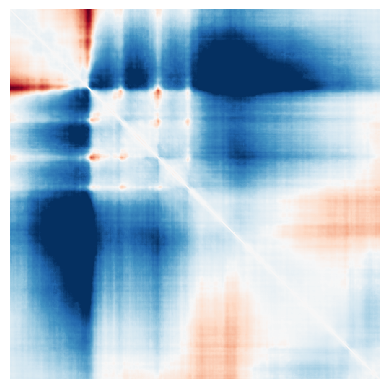

In [12]:
v2_seq_start, v2_seq_end = start - to_expand, end + to_expand
# fetching
seq_1hot = dna_1hot(
        genome_open.fetch(
            chr, v2_seq_start, v2_seq_end
        ).upper()
    )
expanded_seq_1hot = np.expand_dims(seq_1hot, 0)

test_target = test_targets[test_index:test_index+1,:,:]
test_target = np.squeeze(test_target, axis=0)
test_pred = seqnn_model.model.predict(expanded_seq_1hot)

test_pred_maps = ut_dense(test_pred[0,:,:])
ave_test_pred_maps = np.mean(test_pred_maps, axis=2)

# saving
# np.savez(f'{chr}_{start}-{end}_map_v2.npz', prediction=ave_test_pred_maps)

sns.heatmap(
        ave_test_pred_maps,
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
    )

# plt.savefig("genomic_map_example_2.pdf", format="pdf", bbox_inches="tight")
plt.savefig("genomic_map_example_2.png", format="png", bbox_inches="tight")
plt.show()